In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
!pip install cplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 25.2 MB/s eta 0:00:00


In [40]:
!pip install docplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.29.241-py3-none-any.whl size=685423 sha256=06e249e4ae4f0d821780963734277c78557cedd63daf5adff0f88586805b17fe
  Stored in directory: /root/.cache/pip/wheels/2b/15/6e/eba2382ab6bc3f35194a62d3b007916ececf6f07139cac6795
Successfully built docplex


Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 35 rows and 11 columns.
Reduced LP has 47 rows, 24 columns, and 104 nonzeros.
Presolve time = 0.02 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =        673998.207031
Admission Auxiliary model solved successfully.
Worst-case admission demand saved to 'worst_case_admission_quantile_last_12.csv'.


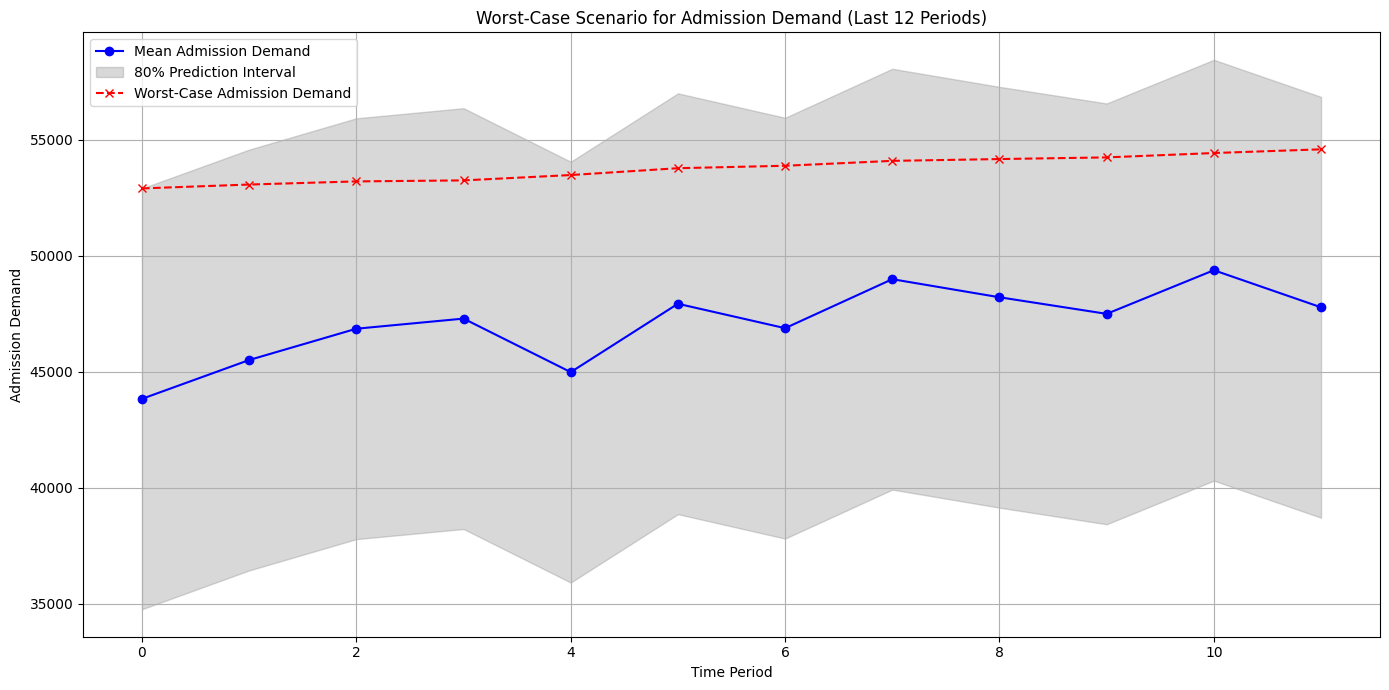

In [41]:
from docplex.mp.model import Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data from CSV
csv_file_path = "admissions_forecast_with_timesteps.csv"  # Replace with your CSV file name
admissions_df = pd.read_csv(csv_file_path)

# Extract the last 12 rows
admissions_df_last_12 = admissions_df.tail(12)

# Extract required columns from the last 12 rows
forecast_adm = admissions_df_last_12['Admissions'].values  # Mean admission demand
lower_bound_adm = admissions_df_last_12['Lower_Bound'].values  # Lower bound
upper_bound_adm = admissions_df_last_12['Upper_Bound'].values  # Upper bound

# Define time periods for the last 12 rows
time_periods_adm = range(len(forecast_adm))  # Number of periods based on the last 12 rows

# Define Uncertainty Budgets for Admissions
GAMMA_1_adm = 0.15  # Adjusted MAPE threshold for admissions
GAMMA_2_adm = 0.10  # Adjusted consecutive change threshold for admissions

# Initialize the Admission Auxiliary Model
aux_model_adm = Model(name="AuxiliaryModel_Admissions")

# Define Decision Variables
o_ht_adm = aux_model_adm.continuous_var_dict(time_periods_adm, name="worst_case_admission")
z_t_adm = aux_model_adm.continuous_var_dict(time_periods_adm, name="absolute_difference_adm")

# Define Objective Function
aux_model_adm.maximize(aux_model_adm.sum(o_ht_adm[t] for t in time_periods_adm))

# Add Constraints
# 1. Demand Bounds
for t in time_periods_adm:
    aux_model_adm.add_constraint(o_ht_adm[t] >= lower_bound_adm[t], f"lower_bound_adm_{t}")
    aux_model_adm.add_constraint(o_ht_adm[t] <= upper_bound_adm[t], f"upper_bound_adm_{t}")

# 2. MAPE Constraints
for t in time_periods_adm:
    aux_model_adm.add_constraint(z_t_adm[t] >= o_ht_adm[t] - forecast_adm[t], f"abs_diff_pos_adm_{t}")
    aux_model_adm.add_constraint(z_t_adm[t] >= forecast_adm[t] - o_ht_adm[t], f"abs_diff_neg_adm_{t}")

total_forecast_adm = sum(forecast_adm)
aux_model_adm.add_constraint(
    aux_model_adm.sum(z_t_adm[t] for t in time_periods_adm) / total_forecast_adm <= GAMMA_1_adm,
    "mape_constraint_adm"
)

# 3. Consecutive-Change Constraints
epsilon_adm = 1e-6
for t in time_periods_adm:
    if t > 0:
        expected_change_adm = abs(forecast_adm[t] - forecast_adm[t - 1])
        diff_abs_t_adm = aux_model_adm.continuous_var(name=f"diff_abs_adm_{t}")

        aux_model_adm.add_constraint(diff_abs_t_adm >= o_ht_adm[t] - o_ht_adm[t - 1], f"diff_pos_adm_{t}")
        aux_model_adm.add_constraint(diff_abs_t_adm >= o_ht_adm[t - 1] - o_ht_adm[t], f"diff_neg_adm_{t}")

        aux_model_adm.add_constraint(
            diff_abs_t_adm / (expected_change_adm + epsilon_adm) <= GAMMA_2_adm,
            f"consecutive_change_adm_{t}"
        )

# Solve the Admission Auxiliary Model
aux_solution_adm = aux_model_adm.solve(log_output=True)

if aux_solution_adm:
    worst_case_adm = [o_ht_adm[t].solution_value for t in time_periods_adm]
    print("Admission Auxiliary model solved successfully.")
else:
    print("No solution found for the Admission Auxiliary model. Using mean forecast as fallback.")
    worst_case_adm = forecast_adm  # Fallback to mean forecast

# Save Admission Results to CSV
worst_case_df_adm = pd.DataFrame({
    'Time Period': list(time_periods_adm),
    'Mean Admission': forecast_adm,
    'Lower Bound': lower_bound_adm,
    'Upper Bound': upper_bound_adm,
    'Worst-Case Admission': worst_case_adm
})
worst_case_df_adm.to_csv("worst_case_admission_quantile_last_12.csv", index=False)
print("Worst-case admission demand saved to 'worst_case_admission_quantile_last_12.csv'.")

# Plot Admission Results
plt.figure(figsize=(14, 7))
plt.plot(time_periods_adm, forecast_adm, label="Mean Admission Demand", color='blue', marker='o')
plt.fill_between(time_periods_adm, lower_bound_adm, upper_bound_adm, color='gray', alpha=0.3, label="80% Prediction Interval")
plt.plot(time_periods_adm, worst_case_adm, label="Worst-Case Admission Demand", color='red', linestyle='--', marker='x')
plt.title("Worst-Case Scenario for Admission Demand (Last 12 Periods)")
plt.xlabel("Time Period")
plt.ylabel("Admission Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 40 rows and 11 columns.
Reduced LP has 42 rows, 24 columns, and 94 nonzeros.
Presolve time = 0.02 sec. (0.05 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =       1162735.970500
Census Auxiliary model solved successfully.
Worst-case census demand saved to 'worst_case_census_quantile_last_12.csv'.


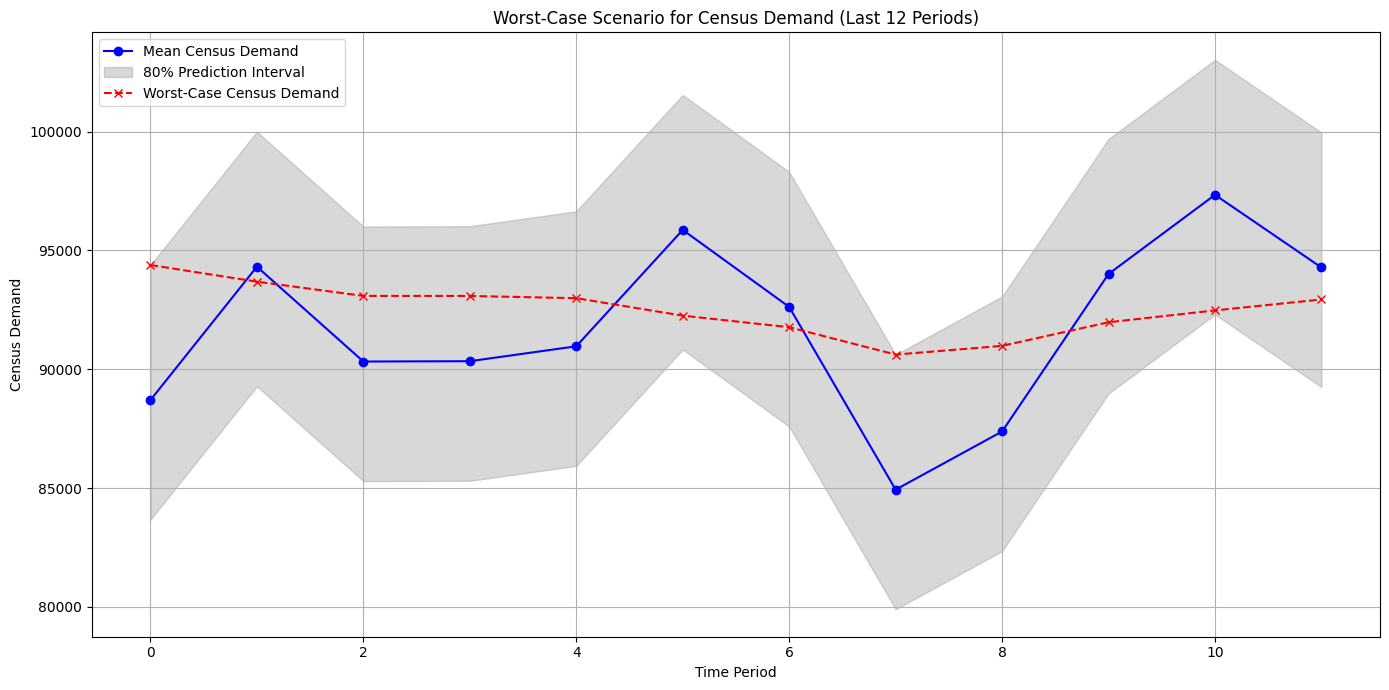

In [42]:
from docplex.mp.model import Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data from CSV
csv_file_path = "census_forecast_with_timesteps.csv"  # Replace with your CSV file name
census_df = pd.read_csv(csv_file_path)

# Extract the last 12 rows
census_df_last_12 = census_df.tail(12)

# Extract required columns from the last 12 rows
forecast_cens = census_df_last_12['Forecast'].values  # Mean census demand
lower_bound_cens = census_df_last_12['Lower_Bound'].values  # Lower bound
upper_bound_cens = census_df_last_12['Upper_Bound'].values  # Upper bound

# Define time periods for the last 12 rows
time_periods_cens = range(len(forecast_cens))  # Number of periods based on the last 12 rows

# Define Uncertainty Budgets for Census
GAMMA_1_cens = 0.20  # MAPE threshold for census
GAMMA_2_cens = 0.15  # Consecutive change threshold for census

# Initialize the Census Auxiliary Model
aux_model_cens = Model(name="AuxiliaryModel_Census")

# Define Decision Variables
o_ht_cens = aux_model_cens.continuous_var_dict(time_periods_cens, name="worst_case_census")
z_t_cens = aux_model_cens.continuous_var_dict(time_periods_cens, name="absolute_difference_cens")

# Define Objective Function
aux_model_cens.maximize(aux_model_cens.sum(o_ht_cens[t] for t in time_periods_cens))

# Add Constraints

# 1. Demand Bounds
for t in time_periods_cens:
    aux_model_cens.add_constraint(o_ht_cens[t] >= lower_bound_cens[t], f"lower_bound_cens_{t}")
    aux_model_cens.add_constraint(o_ht_cens[t] <= upper_bound_cens[t], f"upper_bound_cens_{t}")

# 2. MAPE Constraints
for t in time_periods_cens:
    aux_model_cens.add_constraint(z_t_cens[t] >= o_ht_cens[t] - forecast_cens[t], f"abs_diff_pos_cens_{t}")
    aux_model_cens.add_constraint(z_t_cens[t] >= forecast_cens[t] - o_ht_cens[t], f"abs_diff_neg_cens_{t}")

# MAPE Constraint for Census
total_forecast_cens = sum(forecast_cens)
aux_model_cens.add_constraint(
    aux_model_cens.sum(z_t_cens[t] for t in time_periods_cens) / total_forecast_cens <= GAMMA_1_cens,
    "mape_constraint_cens"
)

# 3. Consecutive-Change Constraints
epsilon_cens = 1e-6
for t in time_periods_cens:
    if t > 0:
        expected_change_cens = abs(forecast_cens[t] - forecast_cens[t - 1])
        diff_abs_t_cens = aux_model_cens.continuous_var(name=f"diff_abs_cens_{t}")

        aux_model_cens.add_constraint(diff_abs_t_cens >= o_ht_cens[t] - o_ht_cens[t - 1], f"diff_pos_cens_{t}")
        aux_model_cens.add_constraint(diff_abs_t_cens >= o_ht_cens[t - 1] - o_ht_cens[t], f"diff_neg_cens_{t}")

        aux_model_cens.add_constraint(
            diff_abs_t_cens / (expected_change_cens + epsilon_cens) <= GAMMA_2_cens,
            f"consecutive_change_cens_{t}"
        )

# Solve the Census Auxiliary Model
aux_solution_cens = aux_model_cens.solve(log_output=True)

if aux_solution_cens:
    worst_case_cens = [o_ht_cens[t].solution_value for t in time_periods_cens]
    print("Census Auxiliary model solved successfully.")
else:
    print("No solution found for the Census Auxiliary model. Using mean forecast as fallback.")
    worst_case_cens = forecast_cens  # Fallback to mean forecast

# Save Census Results to CSV
worst_case_df_cens = pd.DataFrame({
    'Time Period': list(time_periods_cens),
    'Mean Census': forecast_cens,
    'Lower Bound': lower_bound_cens,
    'Upper Bound': upper_bound_cens,
    'Worst-Case Census': worst_case_cens
})
worst_case_df_cens.to_csv("worst_case_census_quantile_last_12.csv", index=False)
print("Worst-case census demand saved to 'worst_case_census_quantile_last_12.csv'.")

# Plot Census Results
plt.figure(figsize=(14, 7))
plt.plot(time_periods_cens, forecast_cens, label="Mean Census Demand", color='blue', marker='o')
plt.fill_between(time_periods_cens, lower_bound_cens, upper_bound_cens, color='gray', alpha=0.3, label="80% Prediction Interval")
plt.plot(time_periods_cens, worst_case_cens, label="Worst-Case Census Demand", color='red', linestyle='--', marker='x')
plt.title("Worst-Case Scenario for Census Demand (Last 12 Periods)")
plt.xlabel("Time Period")
plt.ylabel("Census Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Admissions Forecast Columns: ['Timestep', 'Admissions', 'Lower_Bound', 'Upper_Bound']
LOS7 Columns: ['Timestep', 'Type', 'Value']
LOS14 Columns: ['Timestep', 'Type', 'Value']
LOS21 Columns: ['Timestep', 'Type', 'Value']
Worst-Case Admission Columns: ['Time Period', 'Mean Admission', 'Lower Bound', 'Upper Bound', 'Worst-Case Admission']
Worst-Case Census Columns: ['Time Period', 'Mean Census', 'Lower Bound', 'Upper Bound', 'Worst-Case Census']
Beds Data Columns: ['Unnamed: 0', 'Month', 'G&A beds available', 'G&A core beds available', 'G&A escalation beds available', 'G&A covid void beds', 'G&A beds occupied', 'G&A occupancy rate', 'G&A occupancy rate adjusted for covid void beds', 'Adult G&A beds available', 'Adult core beds available', 'Adult escalation beds available', 'Adult G&A covid void beds', 'Adult G&A beds occupied', 'Adult G&A occupancy rate', 'Adult G&A occupancy rate adjusted for covid void beds', 'Paediatric G&A beds available', 'Paediatric core beds available', 'Paediatric

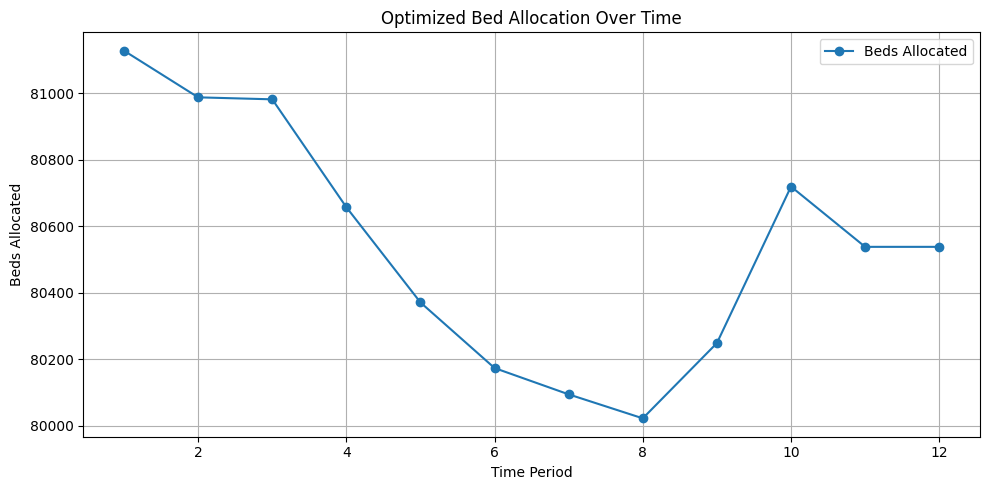

Optimization results saved to 'optimization_results_last_12_periods.csv'.


In [47]:
###############################################################################
# Hospital Capacity Optimization Model with LOS Bins & Mismatch Penalty
###############################################################################
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1) Load Forecast Data (Last 12 Periods)
# ------------------------------------------------------------------

# Define file paths
admissions_forecast_path = "/content/admissions_forecast_with_timesteps.csv"
los7_path = "/content/los7.csv"
los14_path = "/content/los14.csv"
los21_path = "/content/los21.csv"
worst_case_adm_path = "/content/worst_case_admission_quantile_last_12.csv"
worst_case_cens_path = "/content/worst_case_census_quantile_last_12.csv"
beds_data_path = '/content/Beds-publication-Timeseries-March-2020-November-2024 (2) (1) (1) (1) (1).xlsx'

# 1.1 Load Admissions Forecast Data (Last 12 Periods)
admissions_forecast_df = pd.read_csv(admissions_forecast_path).tail(12)

# **Verify Column Names**
print("Admissions Forecast Columns:", admissions_forecast_df.columns.tolist())

# **Assumption:** 'Admissions' represents the mean demand
if 'Admissions' in admissions_forecast_df.columns:
    mean_demand = admissions_forecast_df["Admissions"].values
elif 'Median' in admissions_forecast_df.columns:
    mean_demand = admissions_forecast_df["Median"].values
else:
    raise ValueError("Mean demand column not found in admissions_forecast_with_timesteps.csv.")

# 1.2 Load LOS Forecast Data (Last 12 Periods)
df_7 = pd.read_csv(los7_path).tail(12)
df_14 = pd.read_csv(los14_path).tail(12)
df_21 = pd.read_csv(los21_path).tail(12)

# **Verify Column Names for LOS Forecasts**
print("LOS7 Columns:", df_7.columns.tolist())
print("LOS14 Columns:", df_14.columns.tolist())
print("LOS21 Columns:", df_21.columns.tolist())

# **Assumption:** 'Value' represents the median forecast
if 'Value' in df_7.columns:
    forecast_7 = df_7["Value"].values
else:
    raise ValueError("Forecast column 'Value' not found in los7.csv.")

if 'Value' in df_14.columns:
    forecast_14 = df_14["Value"].values
else:
    raise ValueError("Forecast column 'Value' not found in los14.csv.")

if 'Value' in df_21.columns:
    forecast_21 = df_21["Value"].values
else:
    raise ValueError("Forecast column 'Value' not found in los21.csv.")

# **Verify Lengths**
num_periods = 12  # Since we're using the last 12 periods
assert len(mean_demand) == num_periods, f"mean_demand length {len(mean_demand)} does not match num_periods {num_periods}"
assert len(forecast_7) == num_periods, f"forecast_7 length {len(forecast_7)} does not match num_periods {num_periods}"
assert len(forecast_14) == num_periods, f"forecast_14 length {len(forecast_14)} does not match num_periods {num_periods}"
assert len(forecast_21) == num_periods, f"forecast_21 length {len(forecast_21)} does not match num_periods {num_periods}"

# 1.3 Load Worst-Case Scenarios (Last 12 Periods)
worst_case_adm_df = pd.read_csv(worst_case_adm_path).tail(12)
worst_case_cens_df = pd.read_csv(worst_case_cens_path).tail(12)

# **Verify Column Names for Worst-Case Data**
print("Worst-Case Admission Columns:", worst_case_adm_df.columns.tolist())
print("Worst-Case Census Columns:", worst_case_cens_df.columns.tolist())

# **Assumption:** 'Worst-Case Admission' and 'Worst-Case Census' are the column names
if 'Worst-Case Admission' in worst_case_adm_df.columns:
    worst_case_adm = worst_case_adm_df['Worst-Case Admission'].values
else:
    raise ValueError("Column 'Worst-Case Admission' not found in worst_case_admission_quantile_last_12.csv.")

if 'Worst-Case Census' in worst_case_cens_df.columns:
    worst_case_cens = worst_case_cens_df['Worst-Case Census'].values
else:
    raise ValueError("Column 'Worst-Case Census' not found in worst_case_census_quantile_last_12.csv.")

# **Verify Lengths**
assert len(worst_case_adm) == num_periods, f"worst_case_adm length {len(worst_case_adm)} does not match num_periods {num_periods}"
assert len(worst_case_cens) == num_periods, f"worst_case_cens length {len(worst_case_cens)} does not match num_periods {num_periods}"

# 1.4 Load Beds Data (Last 12 Periods)
beds_data = pd.read_excel(beds_data_path, sheet_name='Timeseries type 1 acute trusts', skiprows=12).tail(12)

# **Verify Column Names**
print("Beds Data Columns:", beds_data.columns.tolist())

# **Rename Columns Appropriately**
beds_data.columns =  [
    "Index", "Month", "G&A beds available", "G&A core beds available",
    "G&A escalation beds available", "G&A covid void beds", "G&A beds occupied",
    "G&A occupancy rate", "G&A occupancy rate adjusted for covid void beds",
    "Adult G&A beds available", "Adult core beds available",
    "Adult escalation beds available", "Adult G&A covid void beds",
    "Adult G&A beds occupied", "Adult G&A occupancy rate",
    "Adult G&A occupancy rate adjusted for covid void beds",
    "Paediatric G&A beds available", "Paediatric core beds available",
    "Paediatric escalation beds available", "Paediatric G&A covid void beds",
    "Paediatric G&A beds occupied", "Paediatric G&A occupancy rate",
    "Paediatric G&A occupancy rate adjusted for covid void beds",
    "Adult critical care beds available", "Adult critical care beds occupied",
    "Adult critical care occupancy rate", "Paediatric intensive care beds available",
    "Paediatric intensive care beds occupied", "Paediatric intensive care occupancy rate",
    "Neonatal intensive care beds available", "Neonatal intensive care beds occupied",
    "Neonatal intensive care occupancy rate", "Placeholder",
    "7 or more days", "14 or more days", "21 or more days",
    "7 or more days.1", "14 or more days.1", "21 or more days.1"
]

# **Clean Beds Data**
beds_data = beds_data.drop(columns=["Index", "Month", "Placeholder"])
beds_data = beds_data.fillna(beds_data.mean())

# **Define Baseline and Occupied Arrays**
baseline_core_beds = beds_data["G&A core beds available"].values * 0.8
baseline_escalation_beds = beds_data["G&A escalation beds available"].values

occupied = np.zeros(num_periods)
occupied[0] = beds_data["G&A beds occupied"].values[0]

true_core_beds_available = np.zeros(num_periods)
for t in range(num_periods):
    if t == 0:
        true_core_beds_available[t] = baseline_core_beds[t]
    else:
        # **Update 'occupied[t]' as per your logic**
        # Example Placeholder Logic:
        # occupied[t] = occupied[t-1] + new_admissions[t-1] - discharges[t-1]
        # Since detailed logic isn't provided, we'll keep it as baseline
        true_core_beds_available[t] = baseline_core_beds[t]

escalation_beds_forecast = np.full(num_periods, baseline_escalation_beds.mean())

# ------------------------------------------------------------------
# 2) Model Parameters
# ------------------------------------------------------------------
uncertainty_margin = 0.3
Gamma = 0.1
setup_cost_per_bed = 10    # Reduced from 100
teardown_cost_per_bed = 3  # Reduced from 30
transfer_cost_per_patient = 20
occupancy_limit = 0.9
core_cost_per_bed = 10
escalation_cost_per_bed = 10
max_transfers = 10
mismatch_penalty = 10000000  # Penalty cost for each unit of mismatch from forecast
num_periods = 12  # Since we're using the last 12 periods
demandslackpenatly=10

# ------------------------------------------------------------------
# 3) Build Optimization Model
# ------------------------------------------------------------------
mdl = Model(name="HospitalCapacityOptimizationWithLOS")

# --- Dynamic bed usage variables ---
core_in_use = mdl.integer_var_list(num_periods, lb=0, name="core_in_use")
esc_in_use  = mdl.integer_var_list(num_periods, lb=0, name="esc_in_use")

core_setup = mdl.integer_var_list(num_periods, lb=0, name="core_setup")
core_teardown = mdl.integer_var_list(num_periods, lb=0, name="core_teardown")
esc_setup = mdl.integer_var_list(num_periods, lb=0, name="esc_setup")
esc_teardown = mdl.integer_var_list(num_periods, lb=0, name="esc_teardown")

# --- LOS-based decision variables ---
x_7   = mdl.integer_var_list(num_periods, lb=0, name="x_7")
x_14  = mdl.integer_var_list(num_periods, lb=0, name="x_14")
x_21  = mdl.integer_var_list(num_periods, lb=0, name="x_21")

beds_allocated = mdl.integer_var_list(num_periods, lb=0, name="beds_allocated")

# Slack variables
slack_demand = mdl.continuous_var_list(num_periods, lb=0, name="slack_demand")
slack_capacity = mdl.continuous_var_list(num_periods, lb=0, name="slack_capacity")
transfers = mdl.integer_var_list(num_periods, lb=0, name="transfers")

# ------------------------------------------------------------------
# 3a) Bed Pool Dynamics
# ------------------------------------------------------------------
# Initial constraints for core beds
mdl.add_constraint(core_in_use[0] <= true_core_beds_available[0], "init_core_in_use")

for t in range(1, num_periods):
    mdl.add_constraint(
        core_in_use[t] == core_in_use[t-1] + core_setup[t] - core_teardown[t],
        f"core_balance_{t}"
    )
    mdl.add_constraint(core_in_use[t] <= true_core_beds_available[t], f"core_avail_{t}")

# Initial constraints for escalation beds
mdl.add_constraint(esc_in_use[0] <= escalation_beds_forecast[0], "init_esc_in_use")

for t in range(1, num_periods):
    mdl.add_constraint(
        esc_in_use[t] == esc_in_use[t-1] + esc_setup[t] - esc_teardown[t],
        f"esc_balance_{t}"
    )
    mdl.add_constraint(esc_in_use[t] <= escalation_beds_forecast[t], f"esc_avail_{t}")

# Total allocated cannot exceed total in-use capacity
for t in range(num_periods):
    mdl.add_constraint(
        beds_allocated[t] <= core_in_use[t] + esc_in_use[t],
        f"alloc_le_inuse_{t}"
    )

# ------------------------------------------------------------------
# 3b) Demand, Capacity, Occupancy Constraints
# ------------------------------------------------------------------
for t in range(num_periods):
    demand_lb = mean_demand[t] * (1 - uncertainty_margin)
    demand_ub = mean_demand[t] * (1 + uncertainty_margin * Gamma)

    # Must allocate at least the lower demand (with slack to handle uncertainty)
    mdl.add_constraint(beds_allocated[t] + slack_demand[t] >= demand_lb, f"demand_lb_{t}")
    mdl.add_constraint(beds_allocated[t] <= demand_ub + slack_demand[t], f"demand_ub_{t}")
    mdl.add_constraint(beds_allocated[t] >= mean_demand[t], f"exact_demand_{t}")

    # Do not exceed physical G&A capacity
    mdl.add_constraint(
        beds_allocated[t] + slack_capacity[t] <= beds_data["G&A beds available"].values[t],
        f"cap_avail_{t}"
    )

    # Occupancy limit
    mdl.add_constraint(
        beds_allocated[t] <= occupancy_limit * beds_data["G&A beds available"].values[t],
        f"occupancy_limit_{t}"
    )

    # Transfer constraints
    mdl.add_constraint(transfers[t] <= slack_demand[t], f"transfer_demand_link_{t}")
    mdl.add_constraint(transfers[t] <= max_transfers, f"max_transfers_{t}")

# ------------------------------------------------------------------
# 3c) Tie Beds Allocated to LOS Bins
# ------------------------------------------------------------------
for t in range(num_periods):
    # The sum of patients in each LOS bin equals total allocated beds
    mdl.add_constraint(
        x_7[t] + x_14[t] + x_21[t] == beds_allocated[t],
        f"los_bins_sum_{t}"
    )

# ------------------------------------------------------------------
# 3d) Mismatch Penalty vs. Forecast
# ------------------------------------------------------------------
# Mismatch variables for each LOS bin
m7_plus   = mdl.continuous_var_list(num_periods, lb=0, name="m7_plus")
m7_minus  = mdl.continuous_var_list(num_periods, lb=0, name="m7_minus")
m14_plus  = mdl.continuous_var_list(num_periods, lb=0, name="m14_plus")
m14_minus = mdl.continuous_var_list(num_periods, lb=0, name="m14_minus")
m21_plus  = mdl.continuous_var_list(num_periods, lb=0, name="m21_plus")
m21_minus = mdl.continuous_var_list(num_periods, lb=0, name="m21_minus")

for t in range(num_periods):
    # x_7[t] - forecast_7[t] = m7_plus[t] - m7_minus[t]
    mdl.add_constraint(
        x_7[t] - forecast_7[t] == m7_plus[t] - m7_minus[t],
        f"mismatch_7_{t}"
    )
    # x_14[t] - forecast_14[t] == m14_plus[t] - m14_minus[t]
    mdl.add_constraint(
        x_14[t] - forecast_14[t] == m14_plus[t] - m14_minus[t],
        f"mismatch_14_{t}"
    )
    # x_21[t] - forecast_21[t] == m21_plus[t] - m21_minus[t]
    mdl.add_constraint(
        x_21[t] - forecast_21[t] == m21_plus[t] - m21_minus[t],
        f"mismatch_21_{t}"
    )

# ------------------------------------------------------------------
# 4) Objective Function
# ------------------------------------------------------------------
mdl.minimize(
    # Cost for using core vs. escalation beds
    mdl.sum(core_cost_per_bed * core_in_use[t] for t in range(num_periods))
    + mdl.sum(escalation_cost_per_bed * esc_in_use[t] for t in range(num_periods))

    # Setup / teardown costs
    + mdl.sum(setup_cost_per_bed * (core_setup[t] + esc_setup[t]) for t in range(num_periods))
    + mdl.sum(teardown_cost_per_bed * (core_teardown[t] + esc_teardown[t]) for t in range(num_periods))

    # Transfer cost
    + mdl.sum(transfer_cost_per_patient * transfers[t] for t in range(num_periods))

    # Slack costs (unmet demand, unused capacity)
    + mdl.sum(1 * slack_demand[t] for t in range(num_periods))
    + mdl.sum(50  * slack_capacity[t] for t in range(num_periods))

    # --- Mismatch Penalty for LOS bins ---
    + mismatch_penalty * mdl.sum(
        (m7_plus[t] + m7_minus[t]
         + m14_plus[t] + m14_minus[t]
         + m21_plus[t] + m21_minus[t])
        for t in range(num_periods)
    )
)

# ------------------------------------------------------------------
# 5) Solve the Model
# ------------------------------------------------------------------
solution = mdl.solve()

# ------------------------------------------------------------------
# 6) Output Results
# ------------------------------------------------------------------
if solution:
    print(f"Objective value (Total Cost): {mdl.objective_value}")
    print("\nOptimization Results:\n")
    for t in range(num_periods):
        print(f"Time Period {t + 1}:")
        print(f"  Core Beds In Use: {core_in_use[t].solution_value}")
        print(f"  Escalation Beds In Use: {esc_in_use[t].solution_value}")
        print(f"  Total Beds Allocated: {beds_allocated[t].solution_value}")
        print(f"    - x_7   = {x_7[t].solution_value} (forecast={forecast_7[t]})")
        print(f"    - x_14  = {x_14[t].solution_value} (forecast={forecast_14[t]})")
        print(f"    - x_21  = {x_21[t].solution_value} (forecast={forecast_21[t]})")
        print(f"  Setup core: {core_setup[t].solution_value}, Teardown core: {core_teardown[t].solution_value}")
        print(f"  Setup esc:  {esc_setup[t].solution_value},  Teardown esc:  {esc_teardown[t].solution_value}")
        print(f"  Transfers: {transfers[t].solution_value}")
        print(f"  Slack Demand: {slack_demand[t].solution_value}")
        print(f"  Slack Capacity: {slack_capacity[t].solution_value}")
        # Print mismatch variables
        print(f"  Mismatch 7+ days: +{m7_plus[t].solution_value}, -{m7_minus[t].solution_value}")
        print(f"  Mismatch 14+ days: +{m14_plus[t].solution_value}, -{m14_minus[t].solution_value}")
        print(f"  Mismatch 21+ days: +{m21_plus[t].solution_value}, -{m21_minus[t].solution_value}")
        print("-" * 50)

    # (Optional) Plot Bed Allocation Over Time
    time_periods = range(1, num_periods + 1)
    allocated_vals = [beds_allocated[t].solution_value for t in range(num_periods)]
    plt.figure(figsize=(10, 5))
    plt.plot(time_periods, allocated_vals, label='Beds Allocated', marker='o')
    plt.xlabel('Time Period')
    plt.ylabel('Beds Allocated')
    plt.title('Optimized Bed Allocation Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (Optional) Save Results to CSV
    results_df = pd.DataFrame({
        'Time Period': list(range(1, num_periods + 1)),
        'Core Beds In Use': [core_in_use[t].solution_value for t in range(num_periods)],
        'Escalation Beds In Use': [esc_in_use[t].solution_value for t in range(num_periods)],
        'Beds Allocated': allocated_vals,
        'x_7': [x_7[t].solution_value for t in range(num_periods)],
        'x_14': [x_14[t].solution_value for t in range(num_periods)],
        'x_21': [x_21[t].solution_value for t in range(num_periods)],
        'Transfers': [transfers[t].solution_value for t in range(num_periods)],
        'Slack Demand': [slack_demand[t].solution_value for t in range(num_periods)],
        'Slack Capacity': [slack_capacity[t].solution_value for t in range(num_periods)],
        'Mismatch 7+': [m7_plus[t].solution_value for t in range(num_periods)],
        'Mismatch 7-': [m7_minus[t].solution_value for t in range(num_periods)],
        'Mismatch 14+': [m14_plus[t].solution_value for t in range(num_periods)],
        'Mismatch 14-': [m14_minus[t].solution_value for t in range(num_periods)],
        'Mismatch 21+': [m21_plus[t].solution_value for t in range(num_periods)],
        'Mismatch 21-': [m21_minus[t].solution_value for t in range(num_periods)],
    })
    results_df.to_csv("optimization_results_last_12_periods.csv", index=False)
    print("Optimization results saved to 'optimization_results_last_12_periods.csv'.")
else:
    print("No solution found.")


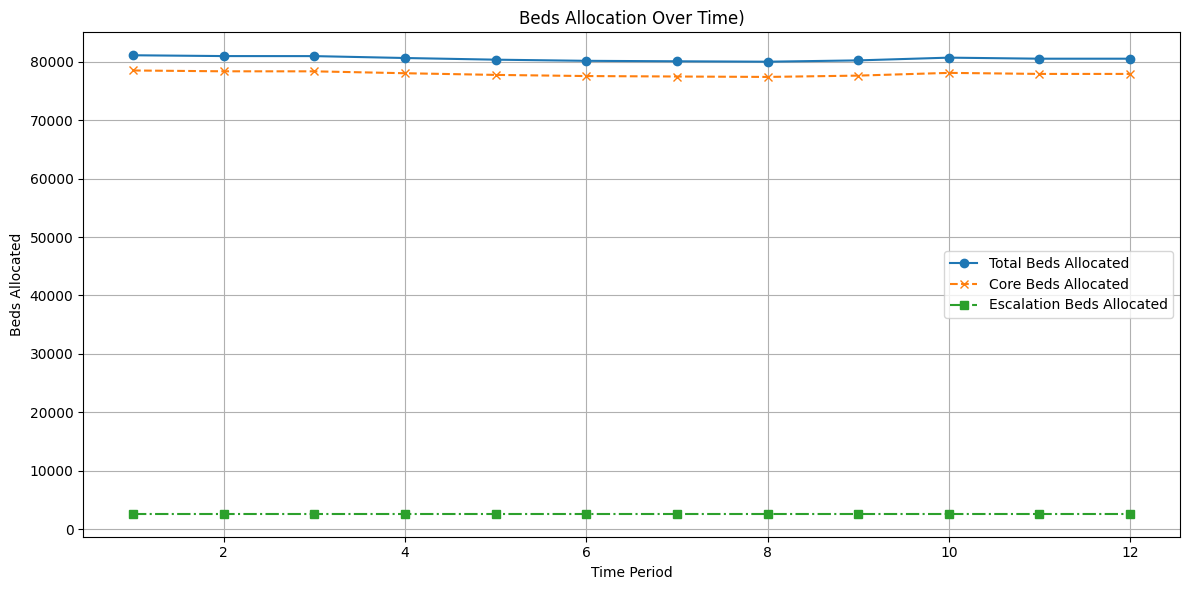

In [48]:
# Plot Beds Allocation Over Time (Including Escalation Beds)
plt.figure(figsize=(12, 6))
time_periods = range(1, num_periods + 1)
total_beds_allocated = [beds_allocated[t].solution_value for t in range(num_periods)]
core_beds_vals = [core_in_use[t].solution_value for t in range(num_periods)]
esc_beds_vals = [esc_in_use[t].solution_value for t in range(num_periods)]

plt.plot(time_periods, total_beds_allocated, label="Total Beds Allocated", marker='o', linestyle='-')
plt.plot(time_periods, core_beds_vals, label="Core Beds Allocated", marker='x', linestyle='--')
plt.plot(time_periods, esc_beds_vals, label="Escalation Beds Allocated", marker='s', linestyle='-.')
plt.xlabel("Time Period")
plt.ylabel("Beds Allocated")
plt.title(f"Beds Allocation Over Time)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
